In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji, string
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv('DataSet.csv')
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

df.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mervseah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(17880, 18)

In [2]:
display(df)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,<p>Vend is looking for some awesome new talent...,<p>Just in case this is the first time you’ve ...,<p>To ace this role you:</p>\r\n<ul>\r\n<li>Wi...,<p><b>What can you expect from us?</b></p>\r\n...,f,t,t,Full-time,Mid-Senior level,NaN,Computer Software,Sales,f,f
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,<p>WebLinc is the e-commerce platform and serv...,<p></p>\r\n<p>The Payroll Accountant will focu...,<p></p>\r\n<p>- B.A. or B.S. in Accounting</p>...,<p></p>\r\n<h3>Health &amp; Wellness</h3>\r\n<...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,f,f
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,<p>We Provide Full Time Permanent Positions fo...,<p>Experienced Project Cost Control Staff Engi...,<ul>\r\n<li>At least 12 years professional exp...,NaN,f,f,f,Full-time,NaN,NaN,NaN,NaN,f,f
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,<p>Nemsia Studios is looking for an experience...,<p>1. Must be fluent in the latest versions of...,<p>Competitive salary (compensation will be ba...,f,f,t,Contract,Not Applicable,Professional,Graphic Design,Design,f,f


## 1. Exploratory Data Analysis

In [3]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
                                       title            location department   
0                           Marketing Intern    US, NY, New York  Marketing  \
1  Customer Service - Cloud Video Production      NZ, , Auckland    Success   
2    Commissioning Machinery Assistant (CMA)       US, IA, Wever        NaN   
3          Account Executive - Washington DC  US, DC, Washington      Sales   
4                        Bill Review Manager  US, FL, Fort Worth        NaN   

  salary_range                                    company_profile   
0          NaN  <h3>We're Food52, and we've created a groundbr...  \
1          NaN  <h3>90 Seconds, the worlds Cloud Video Product...   
2          NaN  <h3></h3>\r\n<p>Valor Services provides Workfo...   
3          NaN  <p>Our passion for improving quality of life t...   
4          NaN  <p>SpotSource Solutions LLC is a Global Human ...   

                                         description   
0  <p>Food52, a fast-grow

In [4]:
# Check for basic information about the dataset
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  o

In [5]:
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                          title         location department salary_range   
count                     17880            17534       6333         2868  \
unique                    11231             3105       1337          874   
top     English Teacher Abroad   GB, LND, London      Sales          0-0   
freq                        311              718        551          142   

                                          company_profile   
count                                               14572  \
unique                                               1710   
top     <p>We help teachers get safe &amp; secure jobs...   
freq                                                  726   

                                              description   
count                                               17880  \
unique                                              15095   
top     <p>Play with kids, get paid for it </p>\r\n<p>...   
freq                                            

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64


In [7]:
# Check for duplicate rows and drop them later
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
235


/var/folders/qr/nrj_437j6c97gz0h835gbb2r0000gn/T/ipykernel_30636/2187502205.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette="viridis")


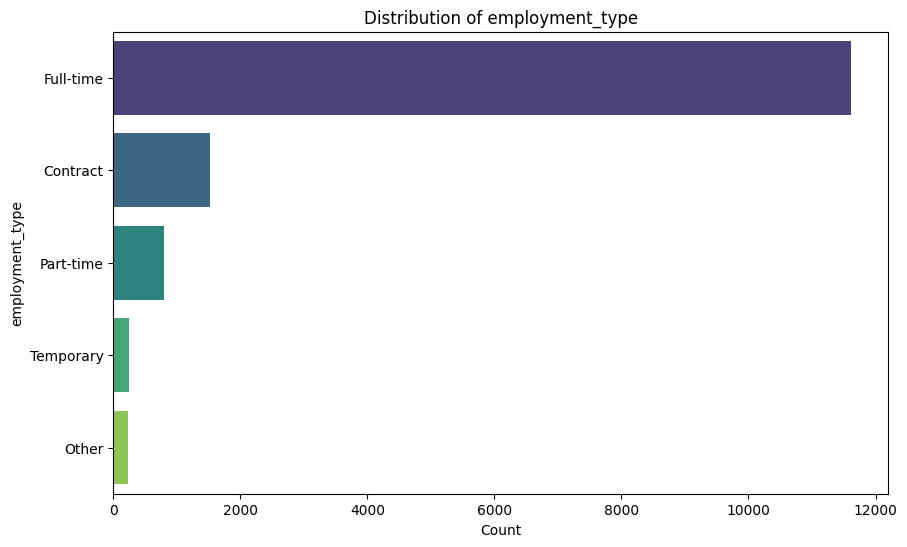

/var/folders/qr/nrj_437j6c97gz0h835gbb2r0000gn/T/ipykernel_30636/2187502205.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette="viridis")


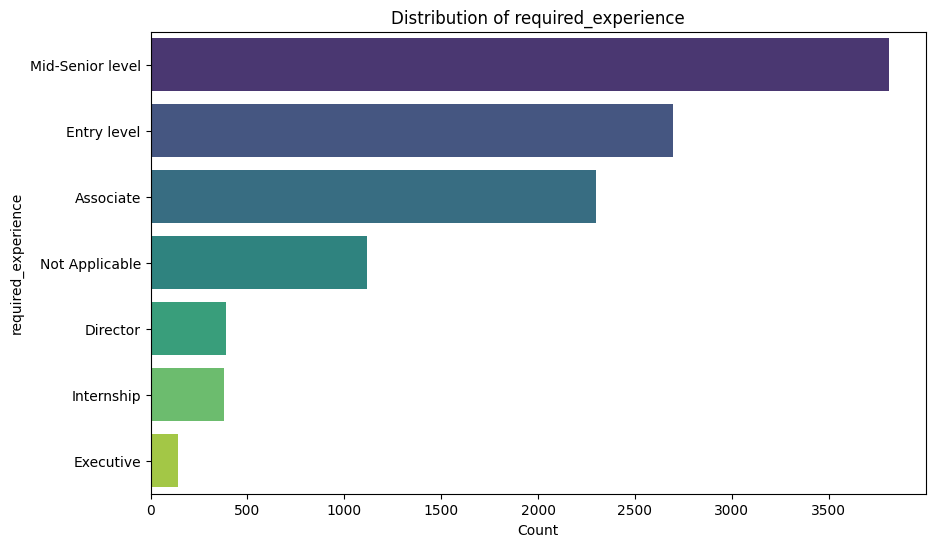

/var/folders/qr/nrj_437j6c97gz0h835gbb2r0000gn/T/ipykernel_30636/2187502205.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette="viridis")


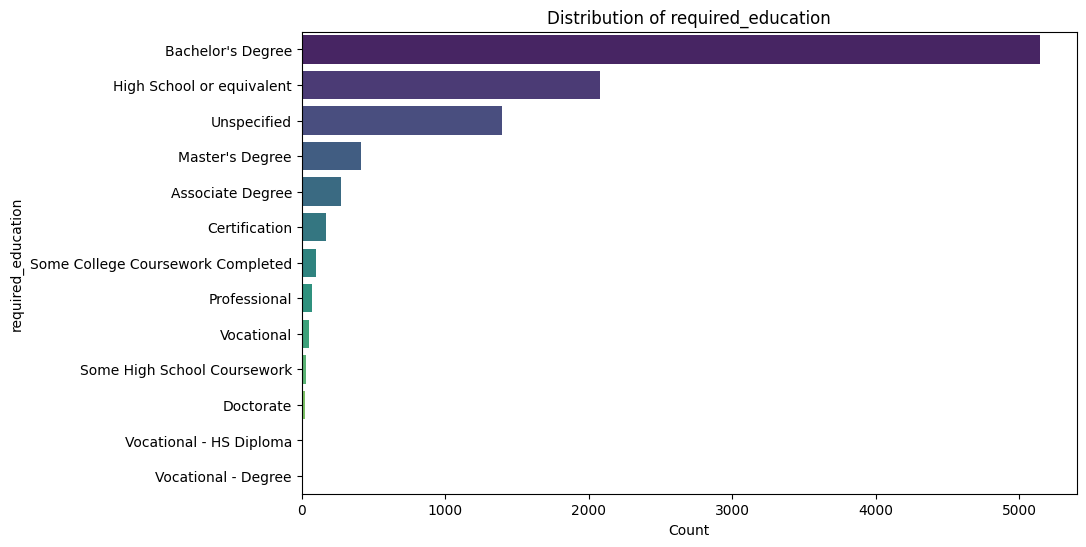

/var/folders/qr/nrj_437j6c97gz0h835gbb2r0000gn/T/ipykernel_30636/2187502205.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette="viridis")


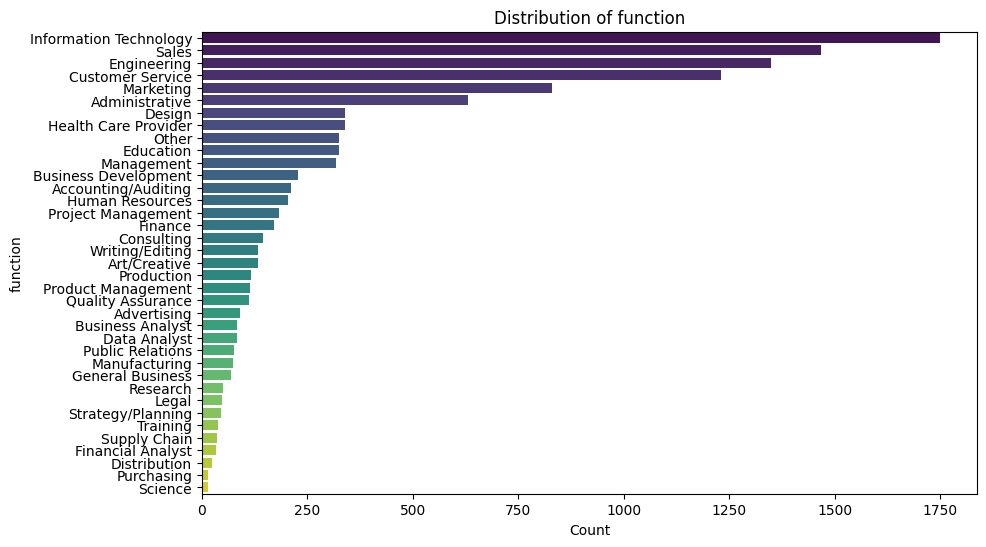

In [8]:
# 1. Bar plot for categorical distributions
categorical_columns = ['employment_type', 'required_experience', 'required_education', 'function']

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

In [9]:
df['salary_range'].unique()

array([nan, '20000-28000', '100000-120000', '120000-150000',
       '50000-65000', '40000-50000', '60-80', '65000-70000', '75-115',
       '75000-110000', '17000-20000', '16000-28000', '95000-115000',
       '15000-18000', '50000-70000', '45000-60000', '30000-40000',
       '70000-90000', '10000-14000', '50-110', '28000-45000', '0-34300',
       '35000-40000', '9-12', '44000-57000', '18500-28000', '55000-75000',
       '30000-35000', '0-0', '20000-40000', '360000-600000',
       '50000-80000', '80000-100000', '52000-78000', '15750-15750',
       '40000-65000', '45000-50000', '30000-37000', '45000-67000',
       '35000-100000', '180000-216000', '45000-65000', '28000-32000',
       '0-1000', '36000-40000', '80000-110000', '35000-73000',
       '19000-19000', '60000-120000', '120000-15000000', '42000-55000',
       '90000-120000', '100000-150000', '28000-38000', '1600-1700',
       '50000-60000', '30000-70000', '32000-40000', '50-100',
       '9000-17000', '23040-28800', '105-110', '13000

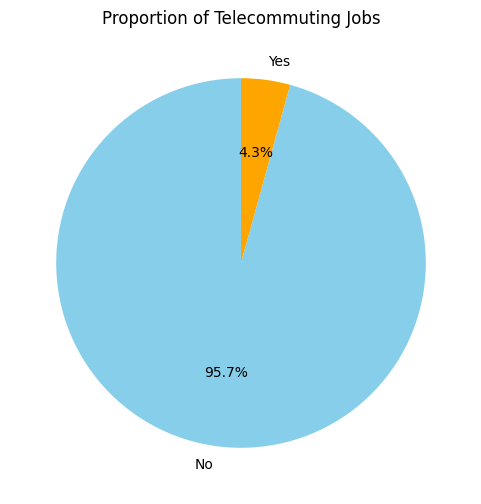

In [10]:
# Proportion of telecommuting jobs
plt.figure(figsize=(6, 6))
telecommuting_counts = df['telecommuting'].value_counts()
telecommuting_counts.plot.pie(autopct='%1.1f%%', labels=['No', 'Yes'], startangle=90, colors=['skyblue', 'orange'])
plt.title('Proportion of Telecommuting Jobs')
plt.ylabel('')
plt.show()

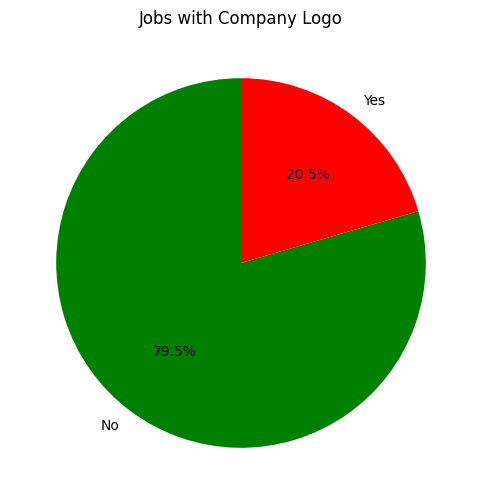

In [11]:
# Proportion of jobs with company logo
plt.figure(figsize=(6, 6))
company_logo_counts = df['has_company_logo'].value_counts()
company_logo_counts.plot.pie(autopct='%1.1f%%', labels=['No', 'Yes'], startangle=90, colors=['green', 'red'])
plt.title('Jobs with Company Logo')
plt.ylabel('')
plt.show()

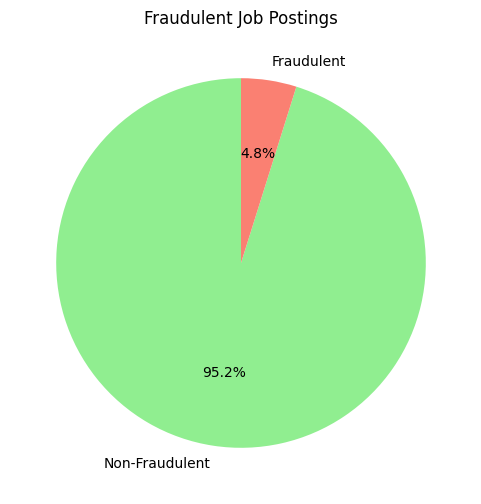

In [12]:
# Fraudulent job postings
plt.figure(figsize=(6, 6))
fraudulent_counts = df['fraudulent'].value_counts()
fraudulent_counts.plot.pie(autopct='%1.1f%%', labels=['Non-Fraudulent', 'Fraudulent'], startangle=90, colors=['lightgreen', 'salmon'])
plt.title('Fraudulent Job Postings')
plt.ylabel('')
plt.show()

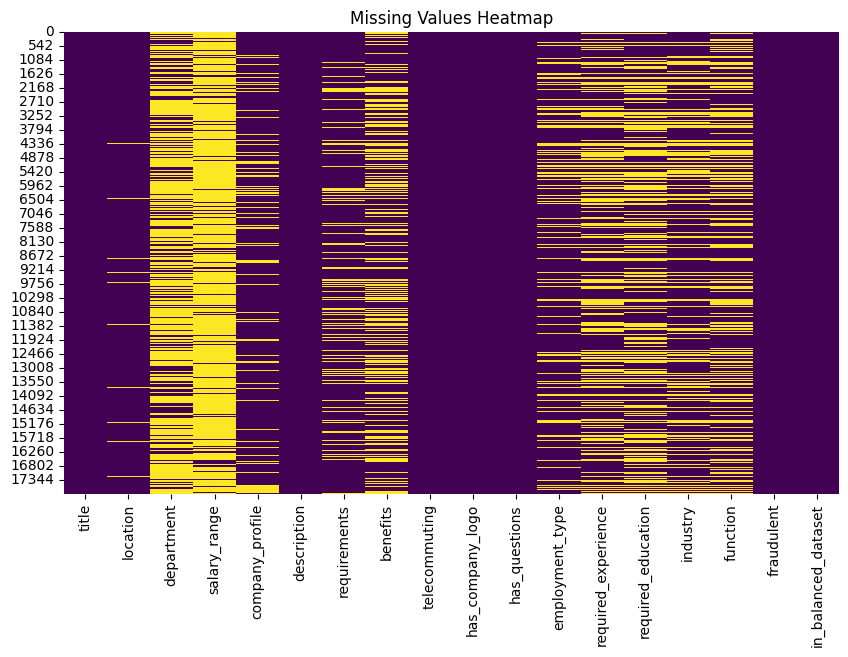

In [13]:
# Missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

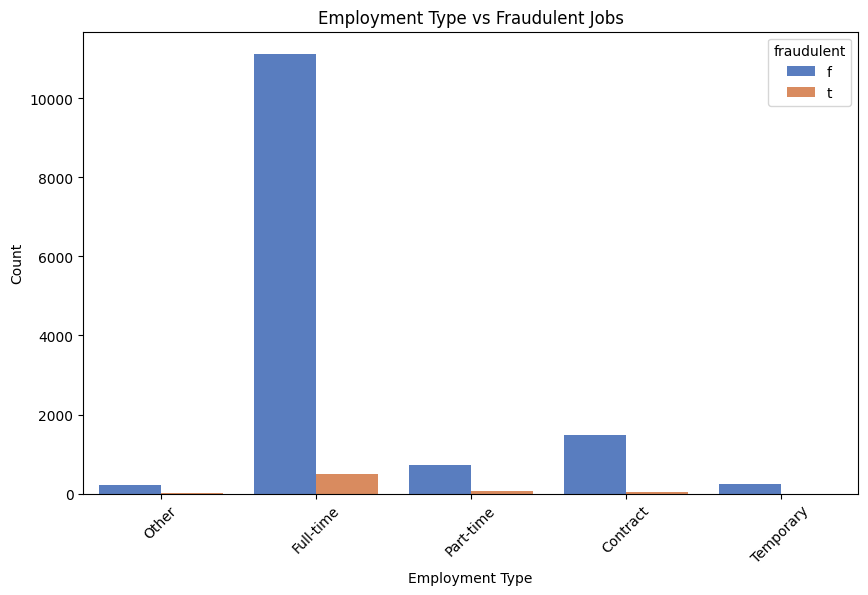

In [14]:
# Relationship between employment type and fraudulent job postings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='employment_type', hue='fraudulent', palette='muted')
plt.title('Employment Type vs Fraudulent Jobs')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


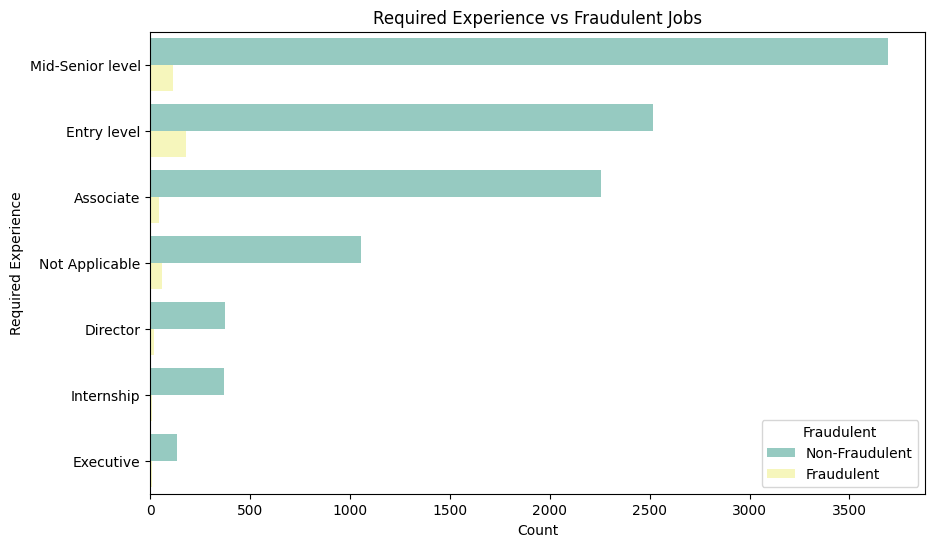

In [15]:
# Count Plot: Required Experience vs Fraudulent
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='required_experience', hue='fraudulent', palette='Set3', order=df['required_experience'].value_counts().index)
plt.title('Required Experience vs Fraudulent Jobs')
plt.xlabel('Count')
plt.ylabel('Required Experience')
plt.legend(title='Fraudulent', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

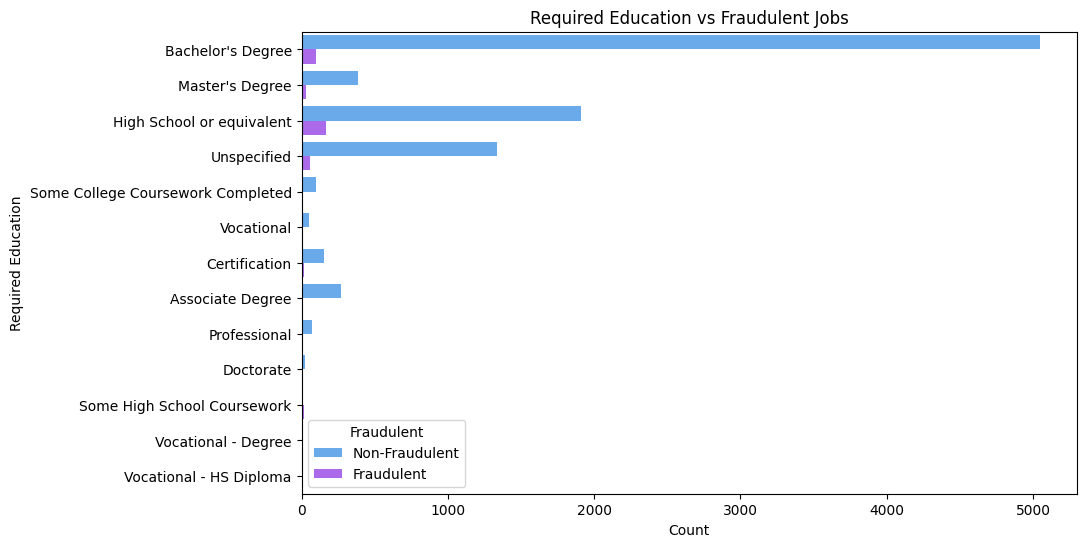

In [16]:
# Required Education vs Fraudulent (Bar Plot)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='required_education', hue='fraudulent', palette='cool')
plt.title('Required Education vs Fraudulent Jobs')
plt.xlabel('Count')
plt.ylabel('Required Education')
plt.legend(title='Fraudulent', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

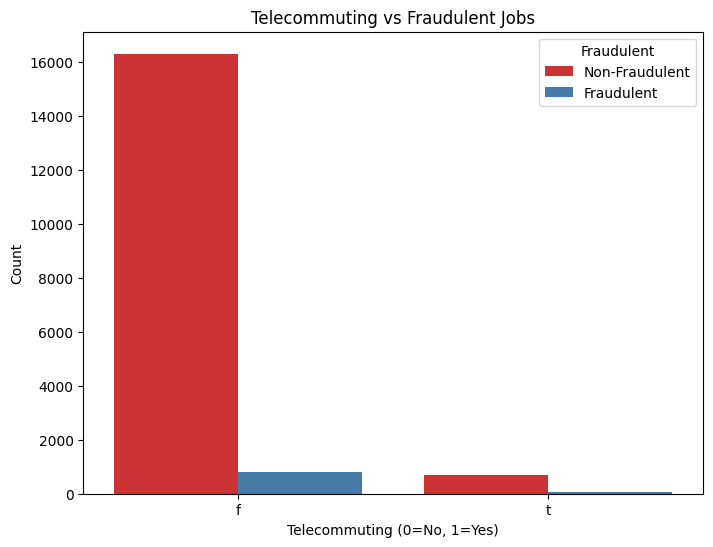

In [17]:
# Telecommuting vs Fraudulent (Bar Plot)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='telecommuting', hue='fraudulent', palette='Set1')
plt.title('Telecommuting vs Fraudulent Jobs')
plt.xlabel('Telecommuting (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

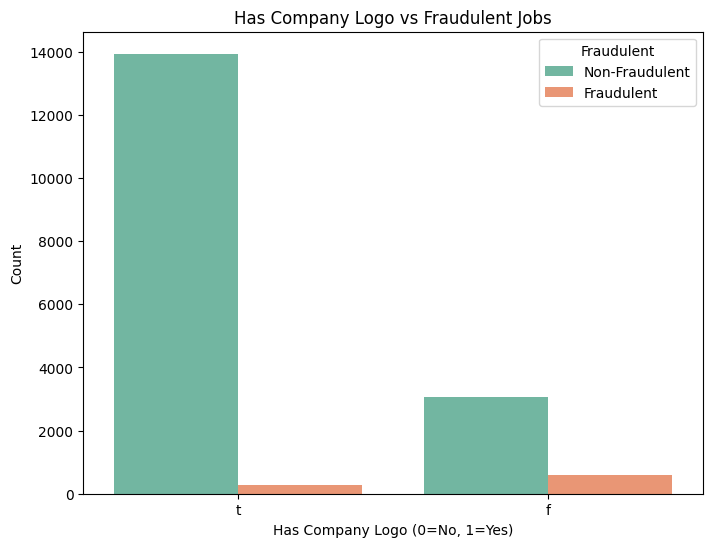

In [18]:
# Has Company Logo vs Fraudulent (Bar Plot)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='Set2')
plt.title('Has Company Logo vs Fraudulent Jobs')
plt.xlabel('Has Company Logo (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

## 2. Data Cleaning

In [19]:
df.drop_duplicates(subset=['title','location', 'department' , 'salary_range', 'company_profile', 'description', 'requirements', 'benefits','telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent'], keep='first', inplace=True)
df.shape

(17632, 18)

## 3. Feature Engineering

In [20]:
## TEXT PREPROCESSING FOR TEXTUAL COLUMNS

# Feature 1: COMBINING TEXTUAL COLUMNS INTO 1 COMBINED TEXT COLUMN

def clean_text_features(text):
    try:
        if pd.isnull(text):
            return ""

        # Remove HTML tags
        text = re.sub(r'<[^>]*>', '', text)

        # Convert to lowercase
        text = text.lower()

        # Remove non-alphanumeric characters (except specified punctuation)
        text = re.sub(r'[^\w\s.,:;!?\'"-]', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove emojis
        #text = emoji.replace_emoji(text, replace="")

        # Remove stopwords
        stop_words = set(stopwords.words("english"))
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        text = " ".join(filtered_words)

        return text

    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""


text_columns = ['title', 'benefits', 'description', 'requirements', 'company_profile']

for col in text_columns:
    df[col] = df[col].apply(clean_text_features)

df['combined_text_data'] = (
    df['title'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['company_profile'] + ' ' +
    df['benefits']
)

# Feature 2: Since there are too many categories for location (3106) hence we decided to perform dimensionality reduction and just limit to the country and perform one-hot-encoding on country column
df['location'] = df['location'].fillna(",,")
df['country']=df['location'].apply(lambda x: x.split(",")[0])

# Dimensionality reduction
unique_locations = df['location'].nunique()
print(f"Number of unique values in 'location': {unique_locations}")

unique_country = df['country'].nunique()
print(f"Number of unique values in 'country': {unique_country}")


## Feature 3: feature engineering new numerical columns based on salary range column

df[['salary_lower', 'salary_upper']] = df['salary_range'].str.split('-', expand=True).astype(float)
df['salary_average'] = (df['salary_lower'] + df['salary_upper']) / 2
df['salary_range_diff'] = df['salary_upper'] - df['salary_lower']



Number of unique values in 'location': 3106
Number of unique values in 'country': 91


In [21]:
## encoding binary columns

binary_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

for column in binary_columns:
    if column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else None))

In [22]:
#One hot encoding for categorical columns

categorical_columns = ['country', 'department', 'employment_type', 'required_experience',
                       'required_education', 'industry', 'function']

df[categorical_columns] = df[categorical_columns].fillna('Unknown')
# Perform one-hot encoding on the specified columns
df = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, drop_first=False)

# Convert all resulting one-hot encoded columns to integers
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [23]:
# DROPPING RAW TEXTUAL COLUMNS THAT ARE UNUSED

columns_to_drop = ['title',
                    'description',
                    'requirements',
                    'company_profile',
                    'benefits',
                    'salary_range',
                    'location',
                    'in_balanced_dataset']

df.drop(columns_to_drop, axis = 1, inplace = True)

## 4a. Train Validation Test Split (Text, Categorical and Numerical columns)
Train-Test-Validation: 70-15-15

Standard scaling for numerical columns

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']  # Target variable to predict

## splitting into training (70%) and remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size = 0.5, random_state=42)

# Scaling numerical columnsx

columns_to_normalize = ['salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
scaler = StandardScaler()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])

for dataset in [X_train, X_val, X_test]:
    display(dataset.shape)

(12342, 1634)

(2645, 1634)

(2645, 1634)

## Train Validation Test Split (Only categorical columns) (No Combined Cleaned Text + No numerical columns)


In [26]:
X = df.drop('fraudulent', axis=1, inplace=False)
y = df['fraudulent']

columns_to_drop2 = ['combined_text_data', 'salary_lower', 'salary_upper', 'salary_average', 'salary_range_diff']
X_cat = X.drop(columns_to_drop2, axis = 1)

## splitting into training (70%) and remaining (30%)
X_train_cat, X_rem_cat, y_train_cat, y_rem_cat = train_test_split(X_cat, y, test_size = 0.3, random_state=42)

## splitting remaining into test (15%) and validation (15%)
X_test_cat, X_val_cat, y_test_cat, y_val_cat = train_test_split(X_rem_cat, y_rem_cat, test_size = 0.5, random_state=42)


for dataset in [X_train_cat, X_val_cat, X_test_cat]:
    display(dataset.shape)

(12342, 1629)

(2645, 1629)

(2645, 1629)

## 5. Embeddings for textual data

In [27]:
#Count Vectorizer Embedding
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train['combined_text_data'])
X_train_count =  count_vect.transform(X_train['combined_text_data'])
X_val_count = count_vect.transform(X_val['combined_text_data'])
X_test_count = count_vect.transform(X_test['combined_text_data'])

#TFIDF Embedding
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['combined_text_data'])
X_train_tfidf = tfidf_vect.transform(X_train['combined_text_data'])
X_val_tfidf = tfidf_vect.transform(X_val['combined_text_data'])
X_test_tfidf = tfidf_vect.transform(X_test['combined_text_data'])

In [28]:
display(X_train_count.shape)
display(X_val_count.shape)
display(X_test_count.shape)

(12342, 60186)

(2645, 60186)

(2645, 60186)

In [29]:
display(X_train_tfidf.shape)
display(X_val_tfidf.shape)
display(X_test_tfidf.shape)

(12342, 60126)

(2645, 60126)

(2645, 60126)

In [30]:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


## 6. Machine Learning Models


### 6.1. Evaluation of different models

In [31]:
dict_result = {}

def update_dict(dict_result, model_name, metric, value):
    if model_name not in dict_result:
        dict_result[model_name] = {}
    dict_result[model_name][metric] = value

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, scoring='roc_auc', dict_result=dict_result):
    """
    Function to train, cross-validate, and evaluate a model.

    Parameters:
        model: The machine learning model (e.g., LogisticRegression, RandomForestClassifier).
        X_train: Features for training.
        y_train: Labels for training.
        X_val: Features for validation.
        y_val: Labels for validation.
        X_test: Features for testing.
        y_test: Labels for testing.
        scoring: Metric for cross-validation (default is 'roc_auc').
    """
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    print(f"Cross-Validation {scoring.upper()} Scores: {cv_scores}")
    print(f"Cross-Validation Mean {scoring.upper()}: {cv_scores.mean():.4f}")

    # Evaluate on validation set
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred_proba)
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Final evaluation on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred)
    # Extract individual elements
    TN, FP, FN, TP = conf_matrix.ravel()
    # Print the confusion matrix as a formatted table
    print("\nConfusion Matrix Table:")
    print(f"{'':<20} {'Predicted Negative':<20} {'Predicted Positive':<20}")
    print(f"{'Actual Negative':<20} {TN:<20} {FP:<20}")
    print(f"{'Actual Positive':<20} {FN:<20} {TP:<20}")
    print("")

    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred)
    recall = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc_score:.4f}")

    # Calculate and plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

    for metric, value in {"cross-validated auc-roc scores": f'{cv_scores}',
                         "cross-validated mean auc-roc": f'{cv_scores.mean():.4f}', 
                         "validation set auc-roc": f'{val_auc:.4f}', 
                         "test accuracy": f'{accuracy:.4f}', 
                         "test precision": f'{precision:.4f}', 
                         "test recall": f'{recall:.4f}', 
                         "test f1": f'{f1:.4f}', 
                         "test auc_score": f'{auc_score:.4f}'}.items():
        
        update_dict(dict_result, model_name, metric, value)

    ## ==== new part =====
    predictions_df = pd.DataFrame({
        'True_Label': y_test,
        'Predicted_Label': test_pred,
        'Predicted_Probability': test_pred_proba
    })

    predictions_csv_path = f"predictions/{model_name}_predictions.csv"
    predictions_df.to_csv(predictions_csv_path, index=False)

In [33]:
def evaluate_keras_nn_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, epochs=20, batch_size=32, dict_result=dict_result):
    """
    Function to train, cross-validate, and evaluate a Keras model.

    Parameters:
        model: The Keras model.
        X_train: Features for training.
        y_train: Labels for training.
        X_val: Features for validation.
        y_val: Labels for validation.
        X_test: Features for testing.
        y_test: Labels for testing.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
    """
    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate on validation set
    val_pred_proba = model.predict(X_val).flatten()  # Keras `predict` for probabilities
    val_auc = roc_auc_score(y_val, val_pred_proba)
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Final evaluation on test set
    test_pred_proba = model.predict(X_test).flatten()  # Probabilities
    test_pred = (test_pred_proba > 0.5).astype(int)  # Binary predictions

    # Metrics
    accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred)
    recall = recall_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test AUC-ROC: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

    for metric, value in {"cross-validated auc-roc scores": None,
                         "cross-validated mean auc-roc": None, 
                         "validation set auc-roc": f'{val_auc:.4f}', 
                         "test accuracy": f'{accuracy:.4f}', 
                         "test precision": f'{precision:.4f}', 
                         "test recall": f'{recall:.4f}', 
                         "test f1": f'{f1:.4f}', 
                         "test auc_score": f'{auc_score:.4f}'}.items():
        
        update_dict(dict_result, model_name, metric, value)

### 6.2. Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
LogRmodel = LogisticRegression(max_iter= 3000)

##### 6.2.1. Categorical variables only

Cross-Validation ROC_AUC Scores: [0.92835989 0.93431477 0.9295924  0.94687155 0.90310853]
Cross-Validation Mean ROC_AUC: 0.9284
Validation AUC-ROC: 0.9055

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      82                   39                  

Test Accuracy: 0.9656
Test Precision: 0.8125
Test Recall: 0.3223
Test F1 Score: 0.4615
Test AUC-ROC: 0.9237


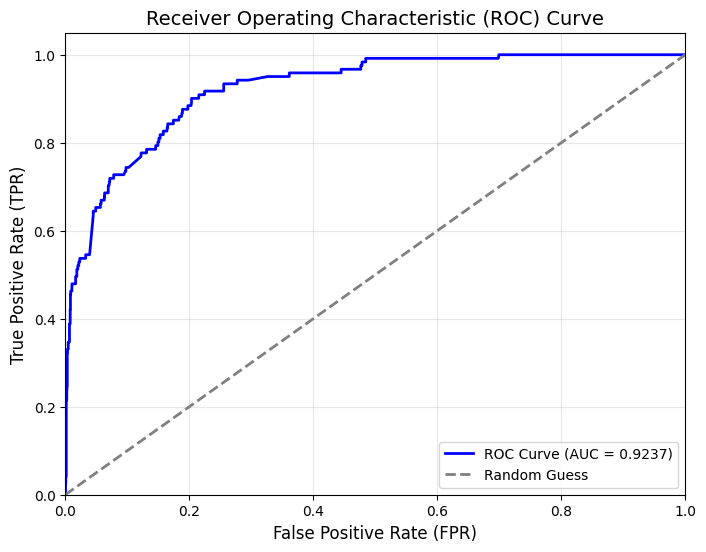

In [35]:
evaluate_model(LogRmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'logreg-cat', scoring='roc_auc')

#### 6.2.2. Count Vect

Cross-Validation ROC_AUC Scores: [0.98092787 0.97603948 0.97438263 0.97924615 0.9861676 ]
Cross-Validation Mean ROC_AUC: 0.9794
Validation AUC-ROC: 0.9592

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      31                   90                  

Test Accuracy: 0.9849
Test Precision: 0.9091
Test Recall: 0.7438
Test F1 Score: 0.8182
Test AUC-ROC: 0.9685


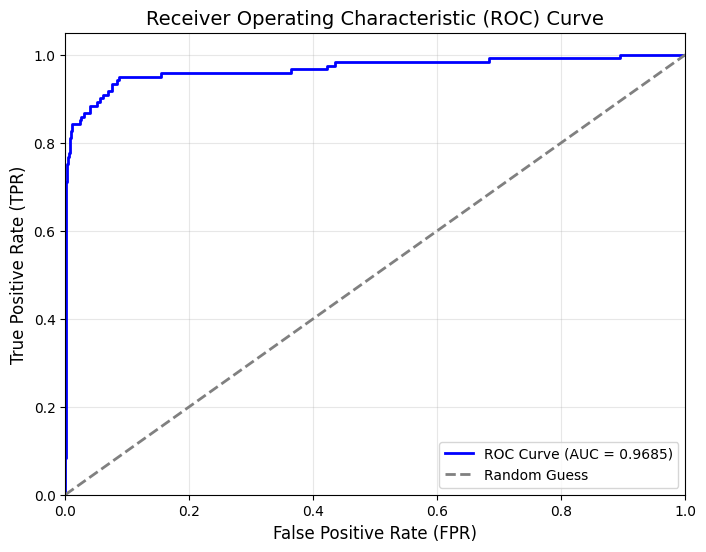

In [36]:
evaluate_model(LogRmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'logreg-count', scoring='roc_auc')

#### 6.2.3. TF-IDF

Cross-Validation ROC_AUC Scores: [0.96960892 0.97374878 0.97504298 0.98235923 0.9847281 ]
Cross-Validation Mean ROC_AUC: 0.9771
Validation AUC-ROC: 0.9508

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2523                 1                   
Actual Positive      70                   51                  

Test Accuracy: 0.9732
Test Precision: 0.9808
Test Recall: 0.4215
Test F1 Score: 0.5896
Test AUC-ROC: 0.9743


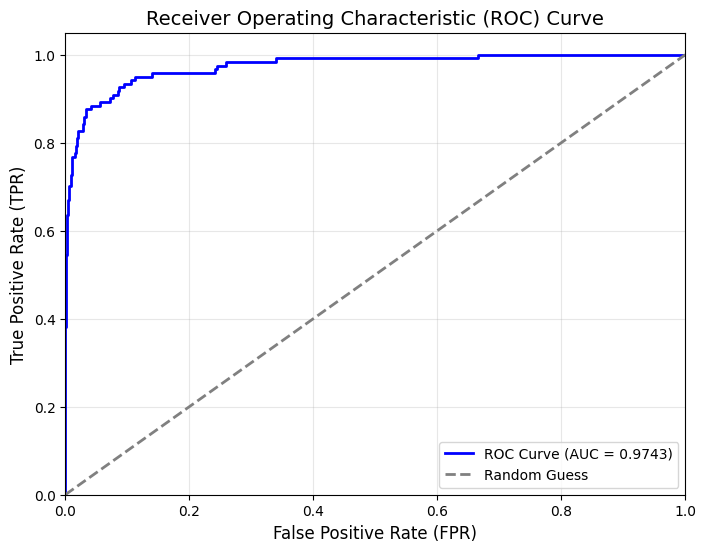

In [37]:
evaluate_model(LogRmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'logreg-tfidf', scoring='roc_auc')

## 6.3. Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_estimators=100, random_state=42)

#### 6.3.1. Categorical variables only

Cross-Validation ROC_AUC Scores: [0.94527719 0.93898107 0.96806738 0.96743148 0.94311559]
Cross-Validation Mean ROC_AUC: 0.9526
Validation AUC-ROC: 0.9539

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      54                   67                  

Test Accuracy: 0.9788
Test Precision: 0.9710
Test Recall: 0.5537
Test F1 Score: 0.7053
Test AUC-ROC: 0.9569


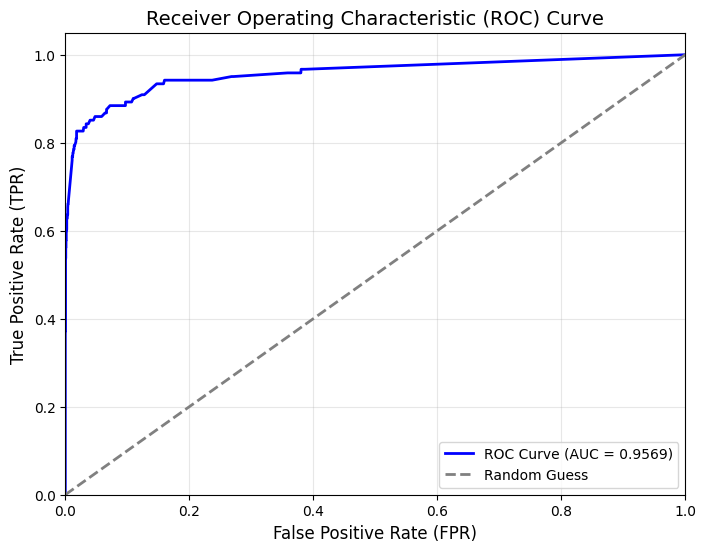

In [39]:
evaluate_model(RFmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'rf-cat', scoring='roc_auc')

#### 6.3.2. Count Vect

Cross-Validation ROC_AUC Scores: [0.97002277 0.98316456 0.98002006 0.98856617 0.98391577]
Cross-Validation Mean ROC_AUC: 0.9811
Validation AUC-ROC: 0.9645

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      42                   79                  

Test Accuracy: 0.9834
Test Precision: 0.9753
Test Recall: 0.6529
Test F1 Score: 0.7822
Test AUC-ROC: 0.9677


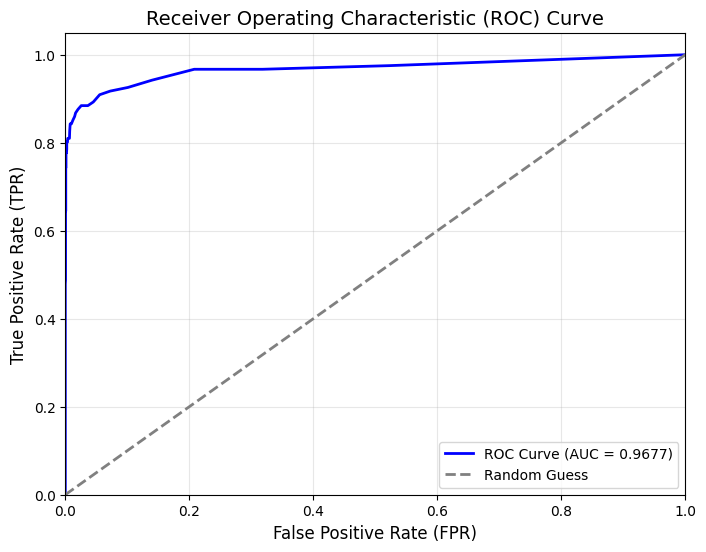

In [40]:
evaluate_model(RFmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'rf-count', scoring='roc_auc')

#### 6.3.3. TF-IDF

Cross-Validation ROC_AUC Scores: [0.96353908 0.96771186 0.96677638 0.98413763 0.98340391]
Cross-Validation Mean ROC_AUC: 0.9731
Validation AUC-ROC: 0.9749

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      42                   79                  

Test Accuracy: 0.9834
Test Precision: 0.9753
Test Recall: 0.6529
Test F1 Score: 0.7822
Test AUC-ROC: 0.9823


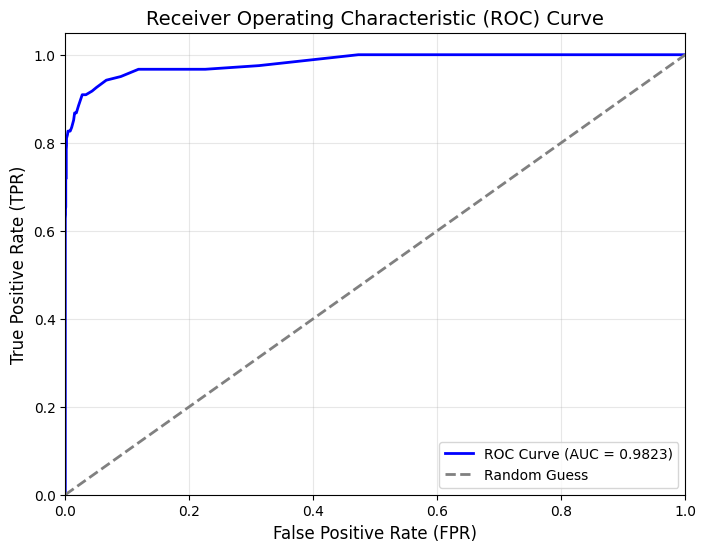

In [41]:
evaluate_model(RFmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'rf-tfidf', scoring='roc_auc')

### 6.4. Decision Tree Classfier

In [42]:
from sklearn.tree import DecisionTreeClassifier
DTmodel = DecisionTreeClassifier(
    max_depth=5,              # Limit the depth of the tree to prevent overfitting
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=5,       # Minimum samples required to be a leaf node
    random_state=42           # Ensure reproducibility
)


#### 6.4.1. Categorical variables only

Cross-Validation ROC_AUC Scores: [0.85113189 0.88557933 0.83913498 0.84983334 0.76267417]
Cross-Validation Mean ROC_AUC: 0.8377
Validation AUC-ROC: 0.7995

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2517                 7                   
Actual Positive      86                   35                  

Test Accuracy: 0.9648
Test Precision: 0.8333
Test Recall: 0.2893
Test F1 Score: 0.4294
Test AUC-ROC: 0.8261


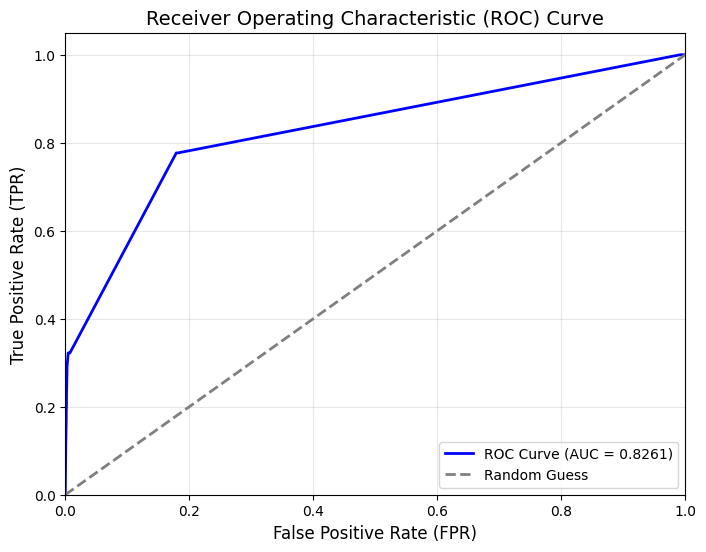

In [43]:
evaluate_model(DTmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'decisionTree-cat', scoring='roc_auc')

#### 6.4.2. Count Vect

Cross-Validation ROC_AUC Scores: [0.61322791 0.64722344 0.63420122 0.63330678 0.64202933]
Cross-Validation Mean ROC_AUC: 0.6340
Validation AUC-ROC: 0.6268

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2517                 7                   
Actual Positive      89                   32                  

Test Accuracy: 0.9637
Test Precision: 0.8205
Test Recall: 0.2645
Test F1 Score: 0.4000
Test AUC-ROC: 0.6298


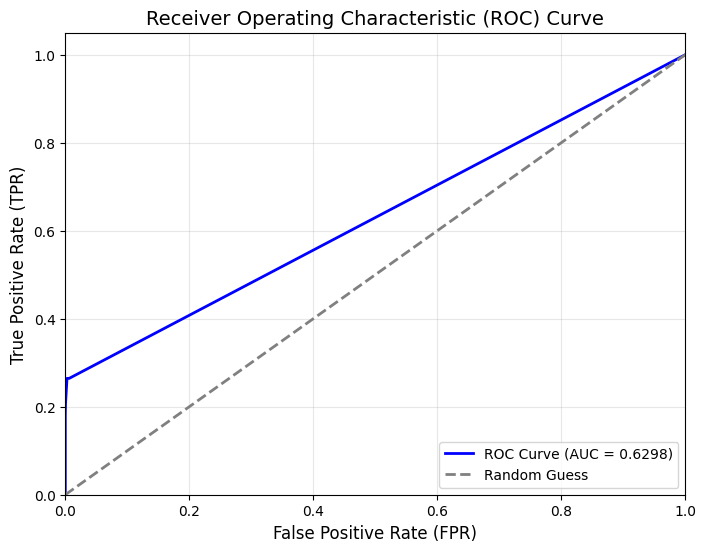

In [44]:
evaluate_model(DTmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'decisionTree-count', scoring='roc_auc')

#### 6.4.3. TF-IDF

Cross-Validation ROC_AUC Scores: [0.6582313  0.65986734 0.6181694  0.64438598 0.63927788]
Cross-Validation Mean ROC_AUC: 0.6440
Validation AUC-ROC: 0.6661

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2519                 5                   
Actual Positive      79                   42                  

Test Accuracy: 0.9682
Test Precision: 0.8936
Test Recall: 0.3471
Test F1 Score: 0.5000
Test AUC-ROC: 0.6711


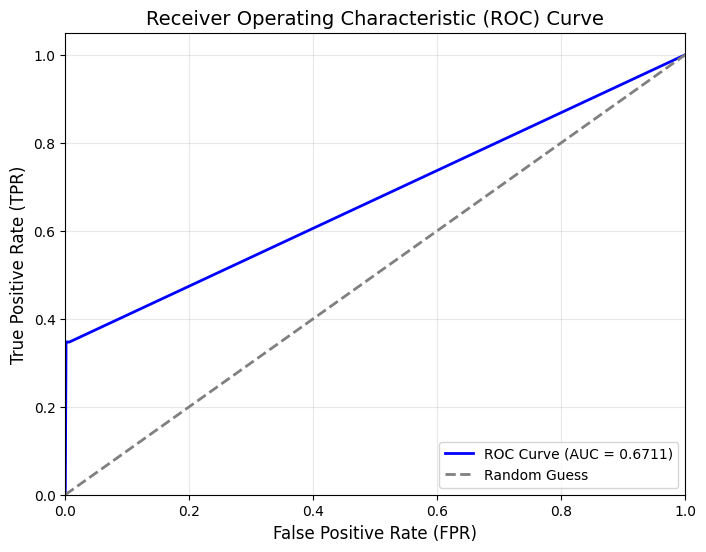

In [45]:
evaluate_model(DTmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'decisionTree-tfidf', scoring='roc_auc')

## 6.5. Support Vector Machine (SVM)

In [46]:
from sklearn.svm import SVC
SVMmodel = SVC(kernel='rbf', probability=True, random_state=42)

#### 6.5.1. Categorical variables only

Cross-Validation ROC_AUC Scores: [0.94196114 0.94815254 0.94829881 0.95719257 0.93898928]
Cross-Validation Mean ROC_AUC: 0.9469
Validation AUC-ROC: 0.9368

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2520                 4                   
Actual Positive      63                   58                  

Test Accuracy: 0.9747
Test Precision: 0.9355
Test Recall: 0.4793
Test F1 Score: 0.6339
Test AUC-ROC: 0.9486


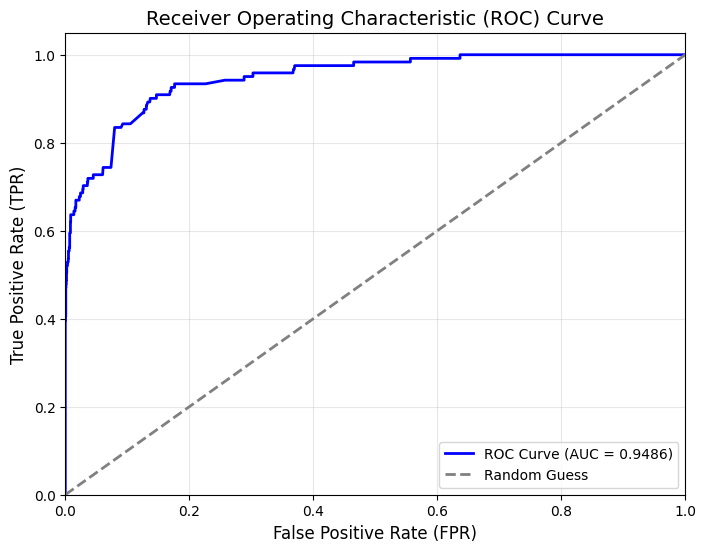

In [47]:
evaluate_model(SVMmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'svm-cat', scoring='roc_auc')

#### 6.5.2. Count Vect

Cross-Validation ROC_AUC Scores: [0.95405366 0.95840351 0.97600031 0.97661524 0.98011264]
Cross-Validation Mean ROC_AUC: 0.9690
Validation AUC-ROC: 0.9532

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      62                   59                  

Test Accuracy: 0.9758
Test Precision: 0.9672
Test Recall: 0.4876
Test F1 Score: 0.6484
Test AUC-ROC: 0.9729


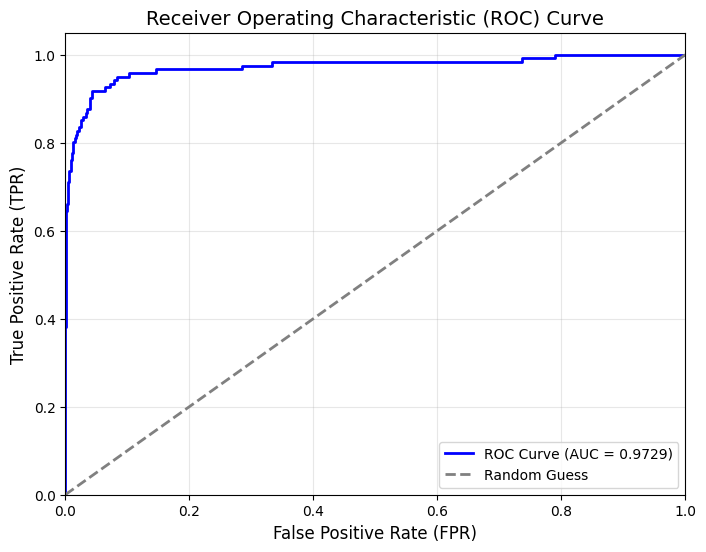

In [48]:
evaluate_model(SVMmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'svm-count', scoring='roc_auc')

#### 6.5.3. TF-IDF

Cross-Validation ROC_AUC Scores: [0.97888131 0.98387499 0.98259332 0.99025547 0.99397649]
Cross-Validation Mean ROC_AUC: 0.9859
Validation AUC-ROC: 0.9585

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2522                 2                   
Actual Positive      48                   73                  

Test Accuracy: 0.9811
Test Precision: 0.9733
Test Recall: 0.6033
Test F1 Score: 0.7449
Test AUC-ROC: 0.9831


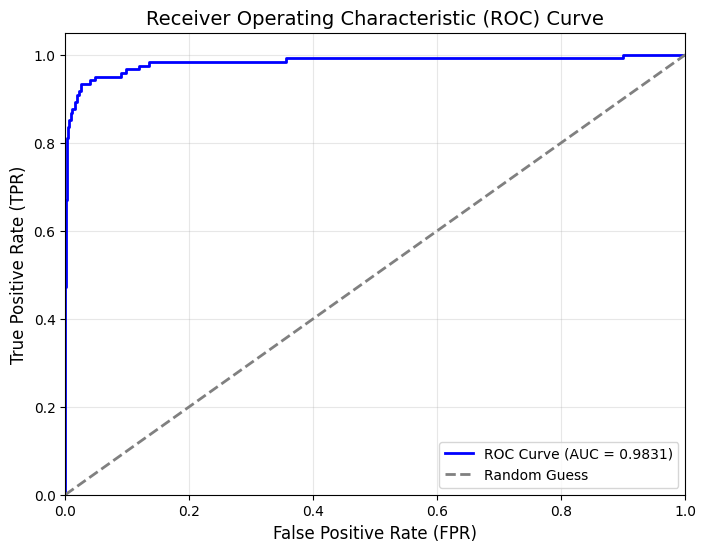

In [49]:
evaluate_model(SVMmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'svm-tfidf', scoring='roc_auc')

### 6.6. XGBOOST

In [50]:
from xgboost import XGBClassifier
XGBmodel = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    use_label_encoder=False,  # Disable label encoder to avoid warnings
    eval_metric='auc',   
    random_state=42,
    verbosity = 0
)

#### 6.6.1. Categorical variables only

Cross-Validation ROC_AUC Scores: [0.95527251 0.95127669 0.95003005 0.96114768 0.93291511]
Cross-Validation Mean ROC_AUC: 0.9501
Validation AUC-ROC: 0.9548

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      63                   58                  

Test Accuracy: 0.9728
Test Precision: 0.8657
Test Recall: 0.4793
Test F1 Score: 0.6170
Test AUC-ROC: 0.9610


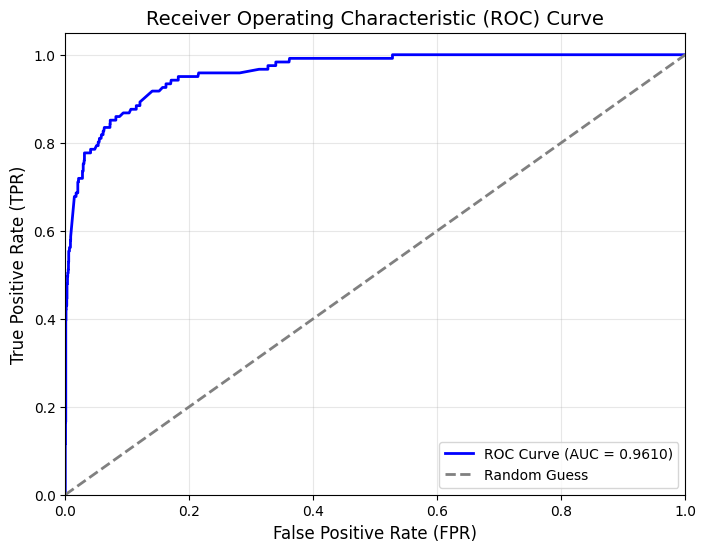

In [51]:
evaluate_model(XGBmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'xgb-cat', scoring='roc_auc')

#### 6.6.2. Count Vect

Cross-Validation ROC_AUC Scores: [0.98426663 0.98171252 0.97084678 0.98377427 0.9843595 ]
Cross-Validation Mean ROC_AUC: 0.9810
Validation AUC-ROC: 0.9663

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2518                 6                   
Actual Positive      46                   75                  

Test Accuracy: 0.9803
Test Precision: 0.9259
Test Recall: 0.6198
Test F1 Score: 0.7426
Test AUC-ROC: 0.9837


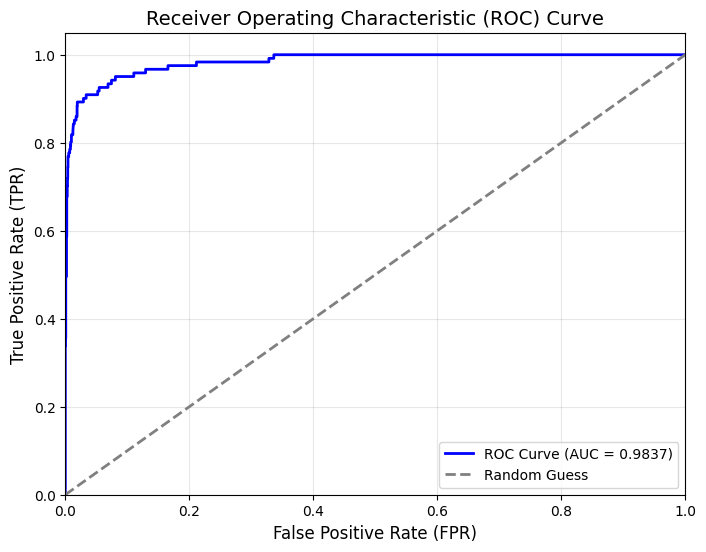

In [52]:
evaluate_model(XGBmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'xgb-count', scoring='roc_auc')

#### 6.6.3. TF-IDF

Cross-Validation ROC_AUC Scores: [0.97718399 0.98303634 0.97356505 0.98395245 0.98468967]
Cross-Validation Mean ROC_AUC: 0.9805
Validation AUC-ROC: 0.9680

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2519                 5                   
Actual Positive      48                   73                  

Test Accuracy: 0.9800
Test Precision: 0.9359
Test Recall: 0.6033
Test F1 Score: 0.7337
Test AUC-ROC: 0.9880


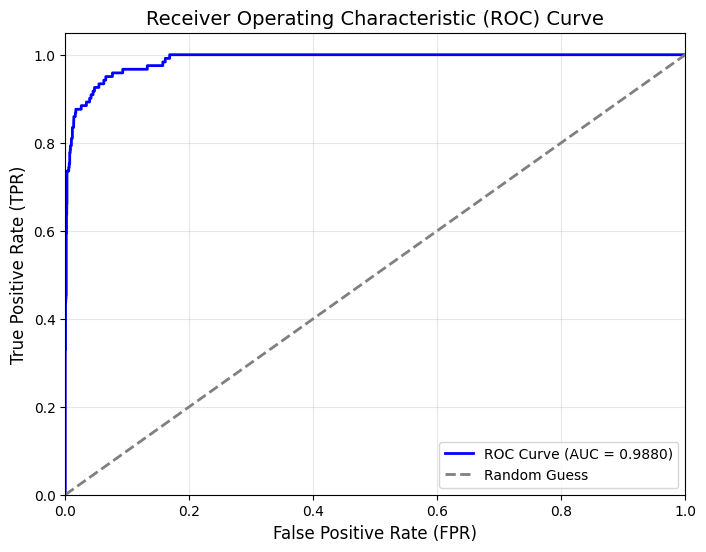

In [53]:
evaluate_model(XGBmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'xgb-tfidf', scoring='roc_auc')

### 6.7. CatBoost

In [54]:
from catboost import CatBoostClassifier

CATmodel = CatBoostClassifier(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    depth=6,                      # Depth of the tree
    loss_function='Logloss',      # Binary classification loss
    eval_metric='AUC',            # Evaluation metric
    random_seed=42,               # Seed for reproducibility
    verbose=0                   # Print training progress every 100 iterations
)

#### 6.7.1. Categorical Variables Only

Cross-Validation ROC_AUC Scores: [0.96124281 0.95372681 0.95813942 0.96293132 0.94861676]
Cross-Validation Mean ROC_AUC: 0.9569
Validation AUC-ROC: 0.9587

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2516                 8                   
Actual Positive      52                   69                  

Test Accuracy: 0.9773
Test Precision: 0.8961
Test Recall: 0.5702
Test F1 Score: 0.6970
Test AUC-ROC: 0.9651


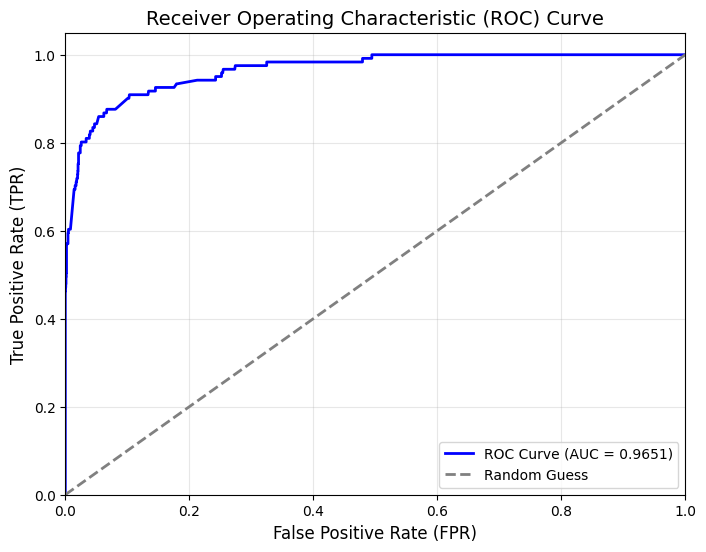

In [55]:
evaluate_model(CATmodel, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'catb-cat', scoring='roc_auc')

#### 6.7.2. Count Vectoriser

Cross-Validation ROC_AUC Scores: [0.97066363 0.97182196 0.96843074 0.98276802 0.97595139]
Cross-Validation Mean ROC_AUC: 0.9739
Validation AUC-ROC: 0.9634

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2520                 4                   
Actual Positive      31                   90                  

Test Accuracy: 0.9868
Test Precision: 0.9574
Test Recall: 0.7438
Test F1 Score: 0.8372
Test AUC-ROC: 0.9806


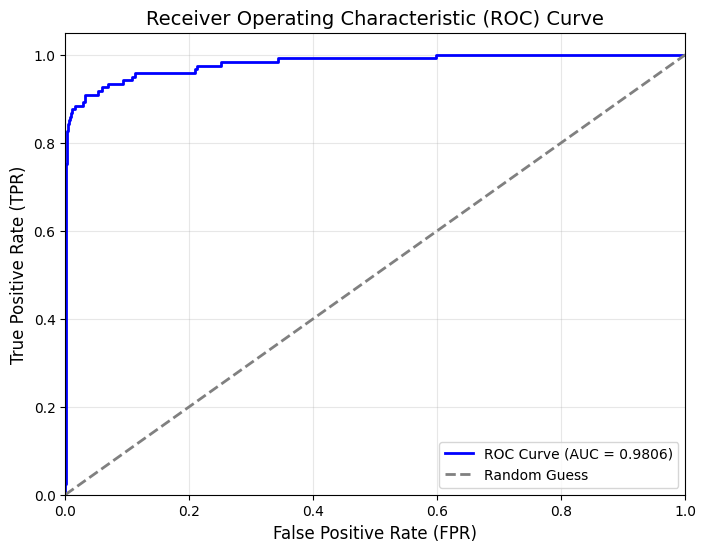

In [56]:
evaluate_model(CATmodel, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'catb-count', scoring='roc_auc')

#### 6.7.3. TFIDF

Cross-Validation ROC_AUC Scores: [0.96670147 0.97798016 0.96957675 0.99114293 0.98351222]
Cross-Validation Mean ROC_AUC: 0.9778
Validation AUC-ROC: 0.9601

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2519                 5                   
Actual Positive      27                   94                  

Test Accuracy: 0.9879
Test Precision: 0.9495
Test Recall: 0.7769
Test F1 Score: 0.8545
Test AUC-ROC: 0.9812


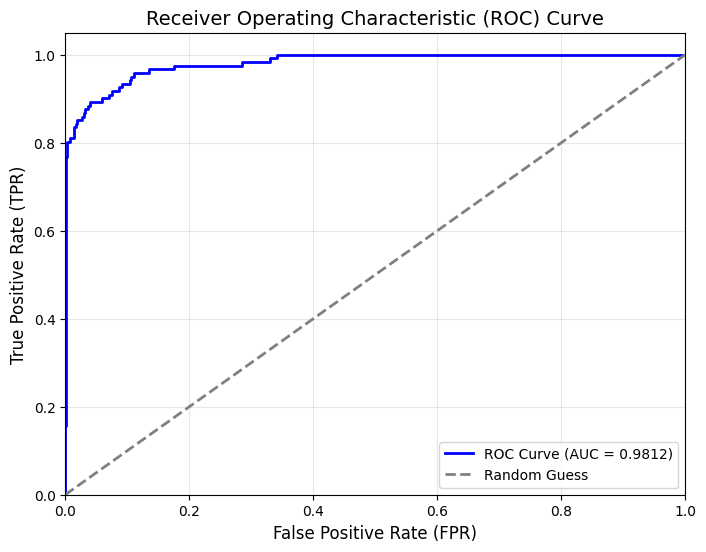

In [57]:
evaluate_model(CATmodel, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'catb-tfidf', scoring='roc_auc')

### 6.8. MLP Classifier

In [58]:
from sklearn.neural_network import MLPClassifier

# MLPClassifier for categorical features
mlp_model_cat = MLPClassifier(
    hidden_layer_sizes=(16, 8),  # Two hidden layers with 16 and 8 neurons respectively
    activation='relu',          # ReLU activation function
    max_iter=50,               # Maximum number of epochs
    random_state=42             # Set a random state for reproducibility
)

# MLPClassifier for count-based features
mlp_model_count = MLPClassifier(
    hidden_layer_sizes=(16, 8),  
    activation='relu',         
    max_iter=50,              
    random_state=42             
)

# MLPClassifier for TF-IDF features
mlp_model_tfidf = MLPClassifier(
    hidden_layer_sizes=(16, 8), 
    activation='relu',     
    max_iter=50,             
    random_state=42
)

#### 6.8.1. Categorical Variable Only

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (

Cross-Validation ROC_AUC Scores: [0.94448791 0.94812481 0.94935747 0.95652873 0.93562988]
Cross-Validation Mean ROC_AUC: 0.9468
Validation AUC-ROC: 0.9405

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2502                 22                  
Actual Positive      47                   74                  

Test Accuracy: 0.9739
Test Precision: 0.7708
Test Recall: 0.6116
Test F1 Score: 0.6820
Test AUC-ROC: 0.9549


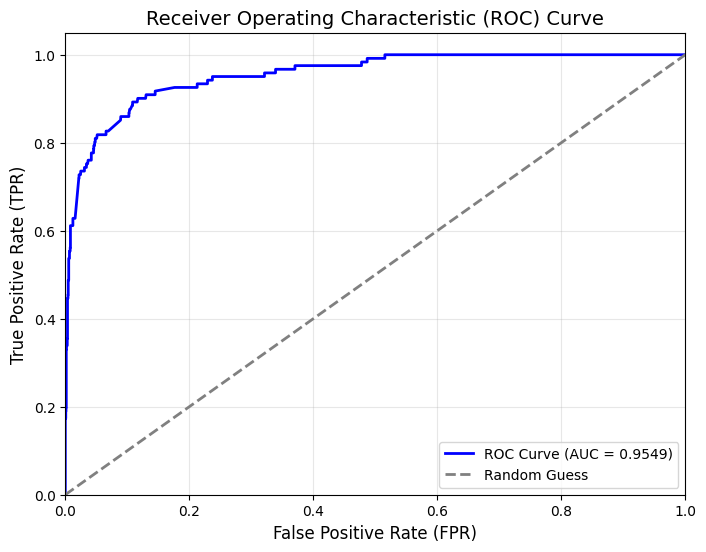

In [59]:
evaluate_model(mlp_model_cat, X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat, 'mlp-cat', scoring='roc_auc')

#### 6.8.2. Count Vectorizer

Cross-Validation ROC_AUC Scores: [0.98136442 0.98132784 0.97618548 0.97613657 0.98173382]
Cross-Validation Mean ROC_AUC: 0.9793
Validation AUC-ROC: 0.9583

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2515                 9                   
Actual Positive      32                   89                  

Test Accuracy: 0.9845
Test Precision: 0.9082
Test Recall: 0.7355
Test F1 Score: 0.8128
Test AUC-ROC: 0.9654


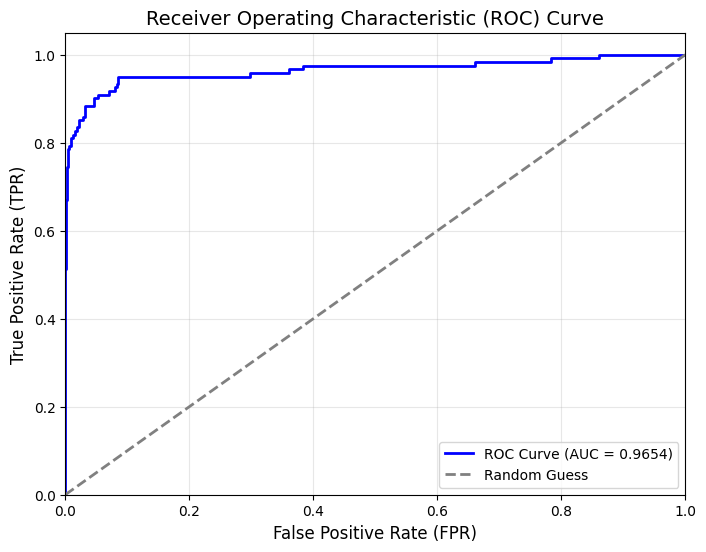

In [60]:
evaluate_model(mlp_model_count,X_train_count, y_train, X_val_count, y_val, X_test_count, y_test, 'mlp-count', scoring='roc_auc')

#### 6.8.3. TFIDF

Cross-Validation ROC_AUC Scores: [0.98782541 0.99150951 0.98250947 0.99119184 0.99128269]
Cross-Validation Mean ROC_AUC: 0.9889
Validation AUC-ROC: 0.9677

Confusion Matrix Table:
                     Predicted Negative   Predicted Positive  
Actual Negative      2517                 7                   
Actual Positive      31                   90                  

Test Accuracy: 0.9856
Test Precision: 0.9278
Test Recall: 0.7438
Test F1 Score: 0.8257
Test AUC-ROC: 0.9852


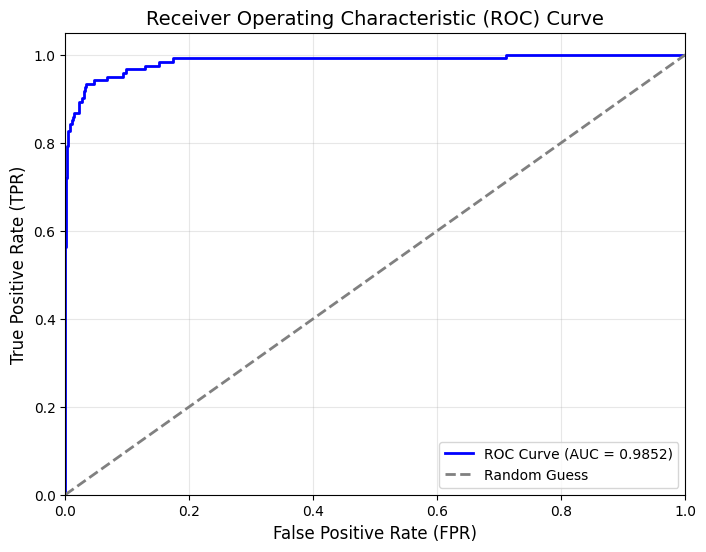

In [61]:
evaluate_model(mlp_model_tfidf,X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, 'mlp-tfidf', scoring='roc_auc')

## 7. Evaluation of Models

In [62]:
mlresults = pd.DataFrame(dict_result).T.rename(columns={'index': 'Model'})
display(mlresults)

,cross-validated auc-roc scores,cross-validated mean auc-roc,validation set auc-roc,test accuracy,test precision,test recall,test f1,test auc_score
logreg-cat,[0.92835989 0.93431477 0.9295924 0.94687155 0...,0.9284,0.9055,0.9656,0.8125,0.3223,0.4615,0.9237
logreg-count,[0.98092787 0.97603948 0.97438263 0.97924615 0...,0.9794,0.9592,0.9849,0.9091,0.7438,0.8182,0.9685
logreg-tfidf,[0.96960892 0.97374878 0.97504298 0.98235923 0...,0.9771,0.9508,0.9732,0.9808,0.4215,0.5896,0.9743
rf-cat,[0.94527719 0.93898107 0.96806738 0.96743148 0...,0.9526,0.9539,0.9788,0.9710,0.5537,0.7053,0.9569
rf-count,[0.97002277 0.98316456 0.98002006 0.98856617 0...,0.9811,0.9645,0.9834,0.9753,0.6529,0.7822,0.9677
rf-tfidf,[0.96353908 0.96771186 0.96677638 0.98413763 0...,0.9731,0.9749,0.9834,0.9753,0.6529,0.7822,0.9823
decisionTree-cat,[0.85113189 0.88557933 0.83913498 0.84983334 0...,0.8377,0.7995,0.9648,0.8333,0.2893,0.4294,0.8261
decisionTree-count,[0.61322791 0.64722344 0.63420122 0.63330678 0...,0.6340,0.6268,0.9637,0.8205,0.2645,0.4000,0.6298
decisionTree-tfidf,[0.6582313 0.65986734 0.6181694 0.64438598 0...,0.6440,0.6661,0.9682,0.8936,0.3471,0.5000,0.6711
svm-cat,[0.94196114 0.94815254 0.94829881 0.95719257 0...,0.9469,0.9368,0.9747,0.9355,0.4793,0.6339,0.9486


## 8. Ensemble Methods

In [63]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

mlresults['test auc_score'] = pd.to_numeric(mlresults['test auc_score'], errors='coerce')

top_models = mlresults.nlargest(3, 'test auc_score').index.tolist()
print("Top 3 Models Based on Test AUC Score:", top_models)

predictions_dict = {}

for model_name in top_models:
    csv_file = f"predictions/{model_name}_predictions.csv"
    
    try:
        predictions_df = pd.read_csv(csv_file)
        
        predictions_dict[model_name] = predictions_df['Predicted_Probability'].values
    except FileNotFoundError:
        print(f"Error: {csv_file} not found. Skipping {model_name}.")


weights = mlresults.loc[top_models, 'test auc_score'].values
weights = weights / np.sum(weights)  # Normalize weights
print("Weights for Soft Voting:", weights)

all_probs = np.array([predictions_dict[model] for model in top_models if model in predictions_dict])

combined_probs = np.average(all_probs, axis=0, weights=weights[:all_probs.shape[0]])

final_predictions = (combined_probs >= 0.5).astype(int)

y_test = predictions_df['True_Label'].values 
accuracy = accuracy_score(y_test, final_predictions)
auc_score = roc_auc_score(y_test, combined_probs)

print(f"Soft Voting Ensemble Accuracy: {accuracy:.4f}")
print(f"Soft Voting Ensemble AUC-ROC: {auc_score:.4f}")

ensemble_predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Combined_Probability': combined_probs,
    'Final_Prediction': final_predictions
})
ensemble_predictions_df.to_csv("soft_voting_ensemble_predictions.csv", index=False)

Top 3 Models Based on Test AUC Score: ['xgb-tfidf', 'mlp-tfidf', 'xgb-count']
Weights for Soft Voting: [0.33413372 0.33318678 0.3326795 ]
Soft Voting Ensemble Accuracy: 0.9822
Soft Voting Ensemble AUC-ROC: 0.9892
